### **说明**   
实验分为3个部分：
1. 单模型: PPO、A2C、TD3
2. 多模型集成策略
3. 单模型增量

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from Config import *
from Stock_trading_environment import StockTradingEnv
from stable_baselines3 import PPO, A2C, TD3
import torch
import optuna
import numpy as np
import os
import datetime
from stable_baselines3.common.env_util import make_vec_env
import copy
from torch import nn

os.environ["KMP_DUPLICATE_LIB_OK"]= "TRUE"
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

TOTAL_TIMESTEPS = int(1e5)

### **加载数据 数据集切分（不考虑模型更新）**  
训练数据："2015-01-01"-"2018-12-31"   
测试数据："2019-01-01"-"2022-08-30"

In [3]:
data = pd.read_csv(r"../Data/New_data/Stock_data.csv")

train_data = data_split(data, TRAIN_START, VALIDATION_END)
test_data = data_split(data, TEST_START, TEST_END)

### **初始化环境env**  
1. 使用Stock_trading_environment.py中StockTradingEnv初始化环境对象env； 
2. 题目给定每天初始资金为1000万。因此，可将每一天作为独立的一个episode，actor根据每一时刻的state给出相应的action，环境会根据相应的action给出相应的reward。单场episode结束的依据：(1) 当前资产净值(股票价值+现金) < 0； (2) 到达当天最后交易时间节点；
3. 单股股票的Action包括：购买(1)，出售(-1), 持有(0)。限定每一时刻可交易的股票数量最大为MAX_VOLUME，Action的选择变为\[-MAX_VOLUME, …, -1, 0, 1, …, MAX_VOLUME\]，StockTradingEnv中Action space使用一维向量表示，取值范围\[-1,1\]，通过MAX_VOLUME * action可将action映射回离散空间，确定实际的交易数量；  
4. 状态空间：使用了63维向量表示当前的交易状态。61维特征包括预处理后的原始特征(除"29"、"33"、"40")、当前股价、当前持有股票数量、持有股票成本、最大资产净值、总出售股票数量、总出售股票均价、总购买股票数量、总购买股票均价、历史均价(当天)、历史股价方差(当天)、交易费用(购买、出售)；
5. $Reward=(action执行后资产净值 - action执行前资产净值) / 1e4$；
6. 实验均未考虑交易费用；(增加交易费用可能需要调整reward function，以避免actor不进行交易)

In [4]:
env_train = StockTradingEnv(df=train_data)
print("Total days available for training:{}".format(env_train.MAX_DAY+1))

env_test = StockTradingEnv(df=test_data)
print("Total days available for testing:{}".format(env_test.MAX_DAY+1))

Total days available for training:916
Total days available for testing:877


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### **模型1**  
1. 采用近端策略优化（PPO）
2. actor和critic均为[128,64,32]全连接网络，前两层网络共享；
3. 模型参数调优参考parameter_tuning.py

Train stage done!(time:0:04:15.967169)


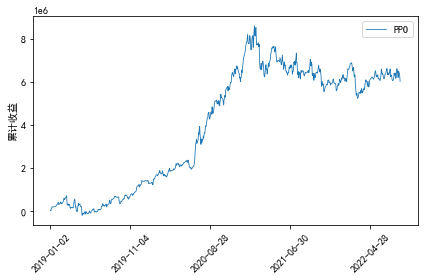

In [5]:
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                         net_arch=[128, 64, dict(pi=[32], vf=[32])])

env_train = StockTradingEnv(df=train_data)
# env_train = make_vec_env(StockTradingEnv, n_envs=20, env_kwargs={"df":train_data, "train_mode":True})
model = PPO("MlpPolicy", env_train, policy_kwargs=policy_kwargs, seed=1024, 
            learning_rate=1e-4, verbose=0, device="cpu")

start_time = datetime.datetime.now()
model.learn(total_timesteps=TOTAL_TIMESTEPS)
env_train.close()
print("Train stage done!(time:{})".format(datetime.datetime.now()-start_time))
model.save(r"../Model/Static_PPO")

# backtest stage
test_data = data_split(data, TEST_START, TEST_END)
env_test = StockTradingEnv(df=test_data)
profit_1 = backtesting_stats(model, env_test, verbose=False)
env_test.close()
draw_profit(test_data["date"].unique(), {"PPO":profit_1})

### **模型2**
1. 采用A2C
2. actor和critic均为[64,64,32]全连接网络，前两层网络共享；

Train stage done!(time:0:04:08.164521)


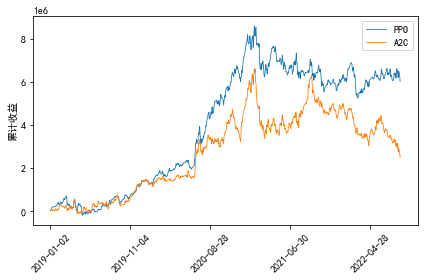

In [6]:
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                         net_arch=[64, 64, dict(pi=[32], vf=[32])])

env_train = StockTradingEnv(df=train_data)
model_1 = A2C("MlpPolicy", env_train, policy_kwargs=policy_kwargs, seed=1024, 
            learning_rate=1e-4, verbose=0, device="cpu")

start_time = datetime.datetime.now()
model_1.learn(total_timesteps=TOTAL_TIMESTEPS)
env_train.close()
print("Train stage done!(time:{})".format(datetime.datetime.now()-start_time))
model_1.save(r"../Model/Static_A2C")

# backtest stage
test_data = data_split(data, TEST_START, TEST_END)
env_test = StockTradingEnv(df=test_data)
profit_2 = backtesting_stats(model_1, env_test, verbose=False)
env_test.close()
draw_profit(test_data["date"].unique(), {"PPO":profit_1, "A2C":profit_2})

### **模型3**
1. 采用TD3

Train stage done!(time:0:10:49.984228)


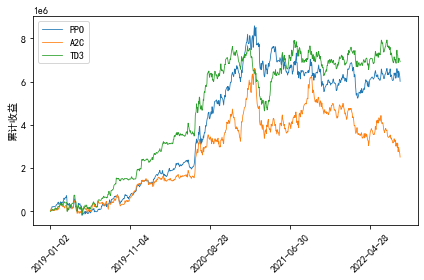

In [7]:
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                         net_arch=[64, 64])

env_train = StockTradingEnv(df=train_data)
model_2 = TD3("MlpPolicy", env_train, policy_kwargs=policy_kwargs, seed=1024, 
            learning_rate=1e-4, verbose=0, buffer_size=500000, device="cpu")

start_time = datetime.datetime.now()
model_2.learn(total_timesteps=TOTAL_TIMESTEPS)
env_train.close()
print("Train stage done!(time:{})".format(datetime.datetime.now()-start_time))
model_2.save(r"../Model/Static_TD3")

# backtest stage
test_data = data_split(data, TEST_START, TEST_END)
env_test = StockTradingEnv(df=test_data)
profit_3 = backtesting_stats(model_2, env_test, verbose=False)
env_test.close()
draw_profit(test_data["date"].unique(), {"PPO":profit_1, "A2C":profit_2, "TD3":profit_3})

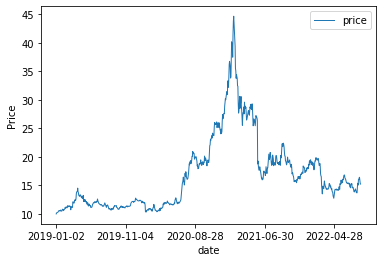
上图为测试集每日收盘价格   
#### 分析:   
(1) TD3和PPO的长期收益高于A2C;   
(2) 股价短时间内大幅回撤时，PPO效果更好；股价小幅回落调整时，TD3效果更好；

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### **多模型集成策略**  
策略1：使用PP0和TD3的action均值进行交易；  
策略2：记录3个model在测试集上的收益，根据sharpe ratio选择下一日的model；

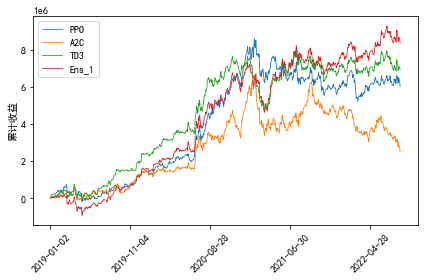

In [8]:
# 根据action的均值进行交易
def ensemble_strategy_1(actor_list, env, verbose=False):
    profit = [] 
    while env.round == 1:
        obs = env.reset()
        while True:
            action_list = []
            for actor in actor_list:
                action_list.append(actor.predict(obs)[0])
            
            action = (np.mean(action_list, axis=0), None)
            obs, _, terminated, info = env.step(action)
            if terminated:
                if verbose:
                    profit.append(env.render())
                else:
                    profit.append(env.cur_shares_worth + env.cur_amount - env.INIT_AMOUNT)
                break
    return profit

test_data = data_split(data, TEST_START, TEST_END)
env_test = StockTradingEnv(df=test_data)    
profit_4 = ensemble_strategy_1(actor_list=[model, model_2], env=env_test, verbose=False)
env_test.close()
draw_profit(test_data["date"].unique(), {"PPO":profit_1, "A2C":profit_2, "TD3":profit_3, "Ens_1": profit_4})

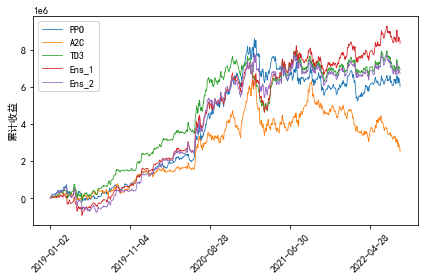

In [9]:
# 根据历史收益的sharpe ratio选择actor
def ensemble_strategy_2(profit_list):
    profit_list = [np.array(i) for i in profit_list]
    profit_opt = []
    for i in range(len(profit_list[0])):
        if i != 0:
            sharpe = [w[:i].mean()/w[:i].std()*np.sqrt(i) for w in profit_list]
        if i != 0:
            index = np.argmax(sharpe)
        else:
            index = np.random.randint(len(profit_list))
        profit_opt.append(profit_list[index][i])
    return profit_opt

profit_5 = ensemble_strategy_2(profit_list=[profit_1, profit_2, profit_3])
draw_profit(test_data["date"].unique(), {"PPO":profit_1, "A2C":profit_2, "TD3":profit_3, "Ens_1": profit_4, "Ens_2": profit_5})

#### 分析：  
集成策略有助于兼顾不同模型间优势（Ens_1长期的累计收益更好; Ens_2相比于TD_3的最大回撤更小）；  
TODO（待定）:不同模型间的差异化配置可能更有效?

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### **模型增量更新（每半年更新一次）**  
1. 每半年进行一次回测，并利用回测后数据进行模型增量更新

In [10]:
def _change_date(now, month=6):
    now = now.split("-")
    if int(now[1])+month > 12:
        now[0] = str(int(now[0]) + 1)
    if int(now[-1]) == 1:
        now[1] = str(int(now[1])+month if int(now[1])+month <= 12 else 1)
        now[1] = "0" + now[1] if len(now[1]) == 1 else now[1] 
    else:
        now[1] = str(int(now[1])+month if int(now[1])+month <= 12 else month)
        now[1] = "0" + now[1] if len(now[1]) == 1 else now[1]
        now[2] = {"03":"31", "06":"30", "09":"30", "12":"31"}[now[1]]       
    return "-".join(now)

test_start = TEST_START
test_end = "2019-06-30"
update_model = copy.deepcopy(model)   #PP0
update_model_1 = model_1    #A2C
update_model_2 = model_2    #TD3

profit_6 = []
profit_7 = []
profit_8 = []
update_time = 1

while True:
    test_data = data_split(data, test_start, test_end)
    env_test = StockTradingEnv(df=test_data)
    print("backtest data range:{}-{}".format(test_start, test_end))
    profit_6 += backtesting_stats(update_model, env_test, verbose=False)
    
    env_test_1 = StockTradingEnv(df=test_data)
    profit_7 += backtesting_stats(update_model_1, env_test_1, verbose=False)
    
    env_test_2 = StockTradingEnv(df=test_data)
    profit_8 += backtesting_stats(update_model_2, env_test_2, verbose=False)
    
    update_model.set_env(env_test)    # reset new env
    update_model_1.set_env(env_test_1)    # reset new env
    update_model_2.set_env(env_test_2)    # reset new env
    
    start_time = datetime.datetime.now()
    update_model.learn(total_timesteps=int(3e4))
    update_model_1.learn(total_timesteps=int(3e4))
    update_model_2.learn(total_timesteps=int(3e4))
    
    env_test.close()
    env_test_1.close()
    env_test_2.close()
    
    print("Update {} time done!(time:{})".format(update_time, datetime.datetime.now()-start_time))
    
    update_model.save(r"../Model/ICL/PPO_{}".format(update_time))
    update_model_1.save(r"../Model/ICL/A2C_{}".format(update_time))
    update_model_2.save(r"../Model/ICL/TD3_{}".format(update_time))
    
    update_time += 1
    
    test_start = _change_date(test_start)
    test_end = _change_date(test_end)
    test_data = data_split(data, test_start, test_end)
    
    if len(test_data) == 0:
        break   

backtest data range:2019-01-01-2019-06-30
Update 1 time done!(time:0:05:43.274588)
backtest data range:2019-07-01-2019-12-31
Update 2 time done!(time:0:05:43.333007)
backtest data range:2020-01-01-2020-06-30
Update 3 time done!(time:0:05:52.028428)
backtest data range:2020-07-01-2020-12-31
Update 4 time done!(time:0:05:48.365093)
backtest data range:2021-01-01-2021-06-30
Update 5 time done!(time:0:05:46.765168)
backtest data range:2021-07-01-2021-12-31
Update 6 time done!(time:0:06:05.397904)
backtest data range:2022-01-01-2022-06-30
Update 7 time done!(time:0:06:10.001658)
backtest data range:2022-07-01-2022-12-31
Update 8 time done!(time:0:06:11.564433)


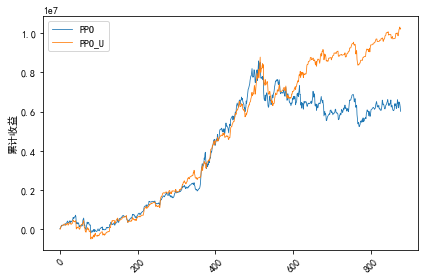

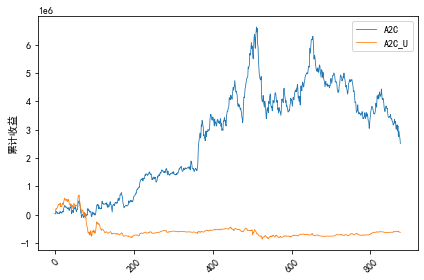

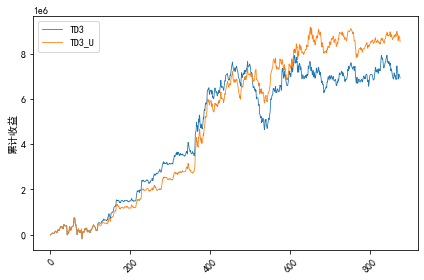

In [11]:
draw_profit(test_data["date"].unique(), 
            {"PPO":profit_1, "PPO_U":profit_6})
draw_profit(test_data["date"].unique(), 
            {"A2C":profit_2, "A2C_U":profit_7})
draw_profit(test_data["date"].unique(), 
            {"TD3":profit_3,"TD3_U":profit_8})

### 分析：  
增量动态调整模型对于TD3和PPO有效，有利于增强模型对于较大回撤的抵御能力；  